In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates

In [3]:
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

## Build Model

In [4]:
# load BTC data

import json
import requests

def get_data_spec(coin, date, time_period,apiKey):
    """ Query the API for 2000 units historical price data starting from "date". """
    url = "https://min-api.cryptocompare.com/data/{}?fsym={}&tsym=USD&limit=2000&toTs={}&api_key={}".format(time_period, coin, date,apiKey)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

def get_news_data_spec(category, timestamp, apiKey, language):
    """ Query the API for 2000 units historical price data starting from "date". """
    url = "https://min-api.cryptocompare.com/data/v2/news/?categories={}&lang={}&lTs={}&api_key={}".format(category, language, timestamp ,apiKey)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

def get_social_data_spec(coin, date, time_frequency, aggregate, apiKey):
    url = "https://min-api.cryptocompare.com/data/social/coin/histo/{}?coinId={}&aggregate={}&limit=2000&toTs={}&api_key={}"\
        .format(time_frequency, coin, aggregate,date,apiKey)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

def get_df_spec(from_date, to_date, time_period, coin, apiKey):
    """ Get historical price data between two dates. If further apart than query limit then query multiple times. """
    date = to_date
    holder = []
    while date > from_date:
        # Now we use the new function to query specific coins
        data = get_data_spec(coin, date, time_period,apiKey)
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom']
    df = pd.concat(holder, axis = 0)
    df = df[df['time']>from_date]
    df['date/hour'] = pd.to_datetime(df['time'], unit='s') 
    df.set_index('date/hour', inplace=True)
    df.sort_index(ascending=True, inplace=True)
    # And just keep the close price, with the column heading as the name of the coin. 
    #df.rename(columns={'close':coin}, inplace=True)
    return df

def get_social_df_spec(from_date, to_date, time_frequency, coin, aggregate, apiKey):
    """ Get historical price data between two dates. If further apart than query limit then query multiple times. """
    date = to_date
    holder = []
    while date > from_date:
        # Now we use the new function to query specific coins
        data = get_social_data_spec(coin, date, time_frequency, aggregate, apiKey)
        data_df = pd.DataFrame(data['Data'])
        holder.append(data_df)
        date = data_df['time'].min()
    df = pd.concat(holder, axis = 0)
    df = df[df['time']>from_date]
    #df['date/hour'] = pd.to_datetime(df['time'], unit='s') 
    df.set_index('time', inplace=True)
    df.sort_index(ascending=True, inplace=True)
    # And just keep the close price, with the column heading as the name of the coin. 
    #df.rename(columns={'close':coin}, inplace=True)
    return df

In [5]:
# # parameters
fromdate = int(datetime.date(2017,1,1).strftime("%s"))
todate = int(datetime.date(2019,4,1).strftime("%s")) #today
coin = 'BTC'
coinID = '1182'
timeperiod = 'histohour'
timefrequency = 'hour'
agg = 1
apiKey = 'bf7c04a024b244dea99e95798fa8e102b7c9738c0933795253c2c8f39f2d160c'
cat = 'BTC'
lang = 'EN'

coin_price = get_df_spec(fromdate, todate, timeperiod, coin, apiKey)

In [6]:
def price_to_return(df, target_col):
    # get price change
    s_test = df[target_col]
    log_return = np.log(s_test/s_test.shift())
    df['price change'] = log_return

    # feature extraction from OHLC
    # '''high/open'''
    df['high/open'] = np.log(df['high']/df['open'])
    # '''low/open'''
    df['low/open'] = np.log(df['low']/df['open'])
    # '''close/high'''
    df['close/high'] = np.log(df['close']/df['high'])
    # '''close/low'''
    df['close/low'] = np.log(df['close']/df['low'])
    df = df.drop(['close','high','low','open','volumefrom'],axis=1)
    df.rename(columns = {'volumeto':'volumn'},inplace=True)
    df = df.dropna()
    return df

coin_return = price_to_return(coin_price,'close')
coin_return.shape


(19687, 7)

In [7]:
coin_return.head()

,time,volumn,price change,high/open,low/open,close/high,close/low
date/hour,,,,,,,
2017-01-01 10:00:00,1483264800,1709340.51,-0.000770,0.000218,-0.009124,-0.000989,0.008354
2017-01-01 11:00:00,1483268400,2171186.38,0.009884,0.011830,0.005244,-0.001947,0.004640
2017-01-01 12:00:00,1483272000,1415767.02,0.002656,0.004074,0.001164,-0.001418,0.001492
2017-01-01 13:00:00,1483275600,612025.92,-0.005961,-0.004018,-0.007710,-0.001943,0.001750
2017-01-01 14:00:00,1483279200,444281.13,0.002974,0.003840,0.001116,-0.000866,0.001858


In [8]:
# filter out duplicates
lst = list(coin_return.time.value_counts()[coin_return.time.value_counts() > 1].index)
coin_return = coin_return[((coin_return['price change'] == 0.0) & (coin_return.time.isin(lst)) ==False)]

In [9]:
coin_return.shape

(19678, 7)

In [10]:
coin_return.head()

,time,volumn,price change,high/open,low/open,close/high,close/low
date/hour,,,,,,,
2017-01-01 10:00:00,1483264800,1709340.51,-0.000770,0.000218,-0.009124,-0.000989,0.008354
2017-01-01 11:00:00,1483268400,2171186.38,0.009884,0.011830,0.005244,-0.001947,0.004640
2017-01-01 12:00:00,1483272000,1415767.02,0.002656,0.004074,0.001164,-0.001418,0.001492
2017-01-01 13:00:00,1483275600,612025.92,-0.005961,-0.004018,-0.007710,-0.001943,0.001750
2017-01-01 14:00:00,1483279200,444281.13,0.002974,0.003840,0.001116,-0.000866,0.001858


## NEWS DATA

In [11]:
news = pd.read_csv('all_news.csv')
news['time'] = news['published_on'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime("%Y-%m-%d"))
news = news.set_index('time')

# get vader sentiment score on news content
news['vader_polarity'] = news['news_content'].apply(lambda x: sia.polarity_scores(x))
news['vader_compound'] = news['vader_polarity'].apply(lambda x: x['compound'])
news['vader_neg'] = news['vader_polarity'].apply(lambda x: x['neg'])
news['vader_neu'] = news['vader_polarity'].apply(lambda x: x['neu'])
news['vader_pos'] = news['vader_polarity'].apply(lambda x: x['pos'])

In [12]:
news = news[['id','published_on','vader_compound','vader_neg','vader_neu','vader_pos']]

In [13]:
news.head()

,id,published_on,vader_compound,vader_neg,vader_neu,vader_pos
time,,,,,,
2019-03-31,1004583,1554101992,0.9042,0.000,0.857,0.143
2019-03-31,1004580,1554101991,-0.5719,0.038,0.954,0.009
2019-03-31,1004582,1554101986,0.7351,0.112,0.656,0.232
2019-03-31,1004429,1554101344,0.4767,0.000,0.964,0.036
2019-03-31,1004416,1554100678,-0.4767,0.178,0.738,0.083


In [14]:
def get_ticker_sentiment(df,news):
    holder = []
    for i in range(df.shape[0]):
        to_t = df.time[i]
        from_t = to_t - 86400
        news_interval = news[(news['published_on'] >= from_t) & (news['published_on'] <= to_t)]
        score = news_interval.mean()[-4:]
        score['time'] = to_t
        holder.append(score)
    score_df = pd.concat(holder,axis=1).T
    score_df['time'] = score_df['time'].apply(int)
    complete_df = pd.merge(df, score_df, on = 'time')
    return complete_df

In [15]:

coin_return_news = get_ticker_sentiment(coin_return,news)

In [16]:
coin_return_news.shape

(19678, 11)

## SOCIAL DATA

In [17]:
coin_social = get_social_df_spec(fromdate,todate,timefrequency,coinID,agg,apiKey)
coin_social.shape

(19688, 32)

In [18]:
# drop duplicates
coin_social = coin_social.reset_index()
coin_social = coin_social.drop_duplicates()
coin_social.set_index('time',inplace = True)
coin_social.shape

(19679, 32)

In [19]:
def get_ticker_social(df,coin_social):
    coin_social = coin_social.pct_change()
    coin_social = coin_social.add(1)
    coin_social = np.log(coin_social)
    coin_social = coin_social.reset_index()
    complete_df = pd.merge(df,coin_social,on='time', how = 'inner')
    return complete_df


In [20]:
coin_complete = get_ticker_social(coin_return_news,coin_social)
coin_complete['time'] = pd.to_datetime(coin_complete['time'], unit='s')
coin_complete['time'] = coin_complete['time'].dt.strftime('%Y-%m-%d %r')
coin_complete.set_index('time', inplace=True)

In [21]:
coin_complete.shape

(19678, 42)

## IMPUTE NULL VALUE

In [22]:
coin_complete = coin_complete.replace([np.inf, -np.inf], np.nan)
coin_complete = coin_complete.fillna(0)
np.any(np.isinf(coin_complete))

volumn                          False
price change                    False
high/open                       False
low/open                        False
close/high                      False
close/low                       False
vader_compound                  False
vader_neg                       False
vader_neu                       False
vader_pos                       False
analysis_page_views             False
charts_page_views               False
code_repo_closed_issues         False
code_repo_closed_pull_issues    False
code_repo_forks                 False
code_repo_open_issues           False
code_repo_open_pull_issues      False
code_repo_stars                 False
code_repo_subscribers           False
comments                        False
fb_likes                        False
fb_talking_about                False
followers                       False
forum_page_views                False
influence_page_views            False
markets_page_views              False
overview_pag

## Normalize

In [23]:
from sklearn.preprocessing import MaxAbsScaler

# def normalized_data(df):
#     min_max_scaler = MinMaxScaler()
#     min_max_scaler.fit_transform(df)
    
max_abs_scaler = MaxAbsScaler()
temp = max_abs_scaler.fit_transform(coin_complete)
temp = pd.DataFrame(temp,columns=coin_complete.columns)
coin_complete = temp.set_index(coin_complete.index)

In [24]:
coin_complete.shape

(19678, 42)

## Time Series to Supervised Learning

In [25]:
def time_series_to_supervised(df,sequence_length, split_line):

    temp = df.values
    temp = temp.tolist()
    result = []
    for index in range(len(temp) - sequence_length):
        result.append(temp[index: index + sequence_length])
    data = np.array(result)
    
    # get x and y
    x = data[:, :-1]
    y = data[:, -1]
    y = y[:, 1] #second column is the price change, which is what we want to predict
    
    # split train and test
    split_line = round(split_line*df.shape[0])
    x_train = x[:int(split_line),:]
    y_train = y[:int(split_line)]
    
    x_test =  x[int(split_line):,:]
    y_test = y[int(split_line):]
    
    return x_train,y_train,x_test,y_test


## Build Model

In [26]:
## Keras for deep learning
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
# import os
# os.environ['KERAS_BACKEND']='tensorflow'

def build_model(input_shape, hidden_size,dropout_value,activation_function, loss_function, optimizer):
    
    #Create a Sequential model using Keras
    model = Sequential()

    #First recurrent layer with dropout
    model.add(Bidirectional(LSTM(hidden_size, return_sequences=True), input_shape=(input_shape[1], input_shape[2]),))
    model.add(Dropout(dropout_value))

    #Second recurrent layer with dropout
    model.add(Bidirectional(LSTM((hidden_size), return_sequences=True)))
    model.add(Dropout(dropout_value))

    #Third recurrent layersequence_length
    model.add(Bidirectional(LSTM(hidden_size, return_sequences=False)))

    #Output layer (returns the predicted value)
    model.add(Dense(units=1))
    
    #Set activation function
    model.add(Activation(activation_function))

    #Set loss function and optimizer
    model.compile(loss=loss_function, optimizer=optimizer)
    
    return model

In [27]:
import time
import math

def fit_model(model, X_train, Y_train, batch_num, num_epoch, val_split):
    """
    Fits the model to the training data
    
    Arguments:
    model -- The previously initalized 3 layer Recurrent Neural Network
    X_train -- A tensor of shape (2400, 49, 35) that represents the x values of the training data
    Y_train -- A tensor of shape (2400,) that represents the y values of the training data
    batch_num -- An integer representing the batch size to be used, in this case 1024
    num_epoch -- An integer defining the number of epochs to be run, in this case 100
    val_split -- A decimal representing the proportion of training data to be used as validation data
    
    Returns:
    model -- The 3 layer Recurrent Neural Network that has been fitted to the training data
    training_time -- An integer representing the amount of time (in seconds) that the model was training
    """
    #Record the time the model starts training
    start = time.time()

    #Train the model on X_train and Y_train
    hist = model.fit(X_train, Y_train, batch_size= batch_num, nb_epoch=num_epoch, validation_split= val_split)

    #Get the time it took to train the model (in seconds)
    training_time = int(math.floor(time.time() - start))
    return model, training_time, hist

## PLOT TRAINING HISTORY

In [28]:
def plot_train_history(history):
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## TEST MODEL

In [44]:
def test_model(model, X_test, Y_test):

    #Test the model on X_Test
    y_predict = model.predict(X_test)
    
    # inverse scaler
    y_predict_inverse = y_predict * max_abs_scaler.scale_[1]
    Y_test_inverse = Y_test * max_abs_scaler.scale_[1]
    
    # put 0 as the first element of the array as baseline
    y_predict_trace = np.insert(y_predict_inverse,0,0)
    Y_test_trace = np.insert(Y_test_inverse,0,0)
    
    # get trace
    # since we are using log return, we use cumsum to recover the trace
    y_predict_trace = y_predict_trace.cumsum()
    Y_test_trace = Y_test_trace.cumsum()
    
    # transform from log return to simple return
    y_predict_trace = np.exp(y_predict_trace)
    Y_test_trace = np.exp(Y_test_trace)
    
    #Plot of the predicted prices versus the real prices
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.set_title("Bitcoin Price Over Time")
    plt.plot(y_predict_trace, color = 'green', label = 'Predicted Price')
    plt.plot(Y_test_trace, color = 'red', label = 'Real Price')
    ax.set_ylabel("Price (USD)")
    ax.set_xlabel("Time (Hours)")
    ax.legend()
    
    return y_predict, fig

## BINARY PRICE TRANSFORMATION


In [31]:
def binary_price(y_predict, y_real):
    """
    Converts percent change to a binary 1 or 0, where 1 is an increase and 0 is a decrease/no change
    
    Arguments:
    delta_predict -- A tensor of shape (267, 1) that represents the predicted percent change in price
    delta_real -- A tensor of shape (267, 1) that represents the real percent change in price
    
    Returns:
    delta_predict_1_0 -- A tensor of shape (267, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (267, 1) that represents the binary version of delta_real
    """
    #Empty arrays where a 1 represents an increase in price and a 0 represents a decrease in price
    y_predict_1_0 = np.empty(y_predict.shape)
    y_real_1_0 = np.empty(y_real.shape)

    #If the change in price is greater than zero, store it as a 1
    #If the change in price is less than zero, store it as a 0
    for i in range(y_predict.shape[0]):
        if y_predict[i] > 0:
            y_predict_1_0[i] = 1
        else:
            y_predict_1_0[i] = 0
    for i in range(y_real.shape[0]):
        if y_real[i] > 0:
            y_real_1_0[i] = 1
        else:
            y_real_1_0[i] = 0    

    return y_predict_1_0, y_real_1_0

In [32]:
def find_positives_negatives(y_predict_1_0, y_real_1_0):
    """
    Finding the number of false positives, false negatives, true positives, true negatives
    
    Arguments: 
    delta_predict_1_0 -- A tensor of shape (267, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (267, 1) that represents the binary version of delta_real
    
    Returns:
    true_pos -- An integer that represents the number of true positives achieved by the model
    false_pos -- An integer that represents the number of false positives achieved by the model
    true_neg -- An integer that represents the number of true negatives achieved by the model
    false_neg -- An integer that represents the number of false negatives achieved by the model
    """
    #Finding the number of false positive/negatives and true positives/negatives
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    for i in range(y_real_1_0.shape[0]):
        real = y_real_1_0[i]
        predicted = y_predict_1_0[i]
        if real == 1:
            if predicted == 1:
                true_pos += 1
            else:
                false_neg += 1
        elif real == 0:
            if predicted == 0:
                true_neg += 1
            else:
                false_pos += 1
    return true_pos, false_pos, true_neg, false_neg

In [42]:
from sklearn.metrics import mean_squared_error

def calculate_statistics(true_pos, false_pos, true_neg, false_neg, y_predict, Y_test):
    """
    Calculate various statistics to assess performance
    
    Arguments:
    true_pos -- An integer that represents the number of true positives achieved by the model
    false_pos -- An integer that represents the number of false positives achieved by the model
    true_neg -- An integer that represents the number of true negatives achieved by the model
    false_neg -- An integer that represents the number of false negatives achieved by the model
    Y_test -- A tensor of shape (267, 1) that represents the normalized y values of the testing data
    y_predict -- A tensor of shape (267, 1) that represents the normalized y values of the model's predictions
    
    Returns:
    precision -- How often the model gets a true positive compared to how often it returns a positive
    recall -- How often the model gets a true positive compared to how often is hould have gotten a positive
    F1 -- The weighted average of recall and precision
    Mean Squared Error -- The average of the squares of the differences between predicted and real values
    """
    precision = float(true_pos) / (true_pos + false_pos)
    recall = float(true_pos) / (true_pos + false_neg)
    F1 = float(2 * precision * recall) / (precision + recall)
    accuracy = float(true_pos + true_neg) / (true_pos + false_pos + true_neg + false_neg)
    #Get Mean Squared Error
    MSE = mean_squared_error(y_predict.flatten(), Y_test.flatten())

    return precision, recall, F1, accuracy, MSE

# ACTUAL TRAIN/TEST/EVALUATION

In [34]:
#parameters
sequence_length = 50
window = sequence_length -1
train_test_split = 0.8
hidden_size = 100
dropout_rate = 0.3
activation = 'linear'
loss = 'mse'
optimizer = Adam(lr=0.001)
batch = 1024
epoch = 100
val_split = 0.2

In [35]:
#data
coin_data = coin_complete

#to_supervised
X_train, Y_train, X_test, Y_test = time_series_to_supervised(coin_data,sequence_length,train_test_split)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(15742, 49, 42) (15742,) (3886, 49, 42) (3886,)


In [90]:
# initialize model
coin_model = build_model(X_train.shape,hidden_size,dropout_rate, activation,loss,optimizer)
print (coin_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 49, 200)           114400    
_________________________________________________________________
dropout_6 (Dropout)          (None, 49, 200)           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 49, 200)           240800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 49, 200)           0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 200)               240800    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                

In [1]:
# model, training_time, history = fit_model(coin_model,X_train,Y_train,batch,epoch, val_split)
# model.save('coin_model_2.h5')
# print ("Training time", training_time, "seconds")

In [36]:
# load model
from tensorflow.keras.models import load_model
model = load_model('coin_model_1.h5')


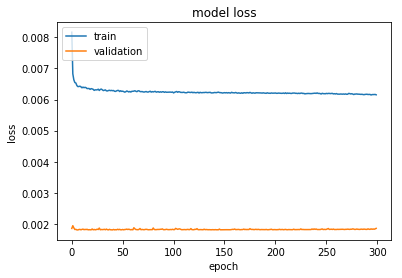

In [83]:
# plot model history
plot_train_history(history)

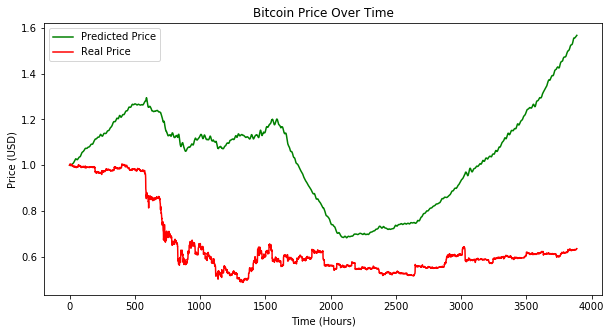

In [45]:
# predict all
y_predict, fig = test_model(model,X_test,Y_test)

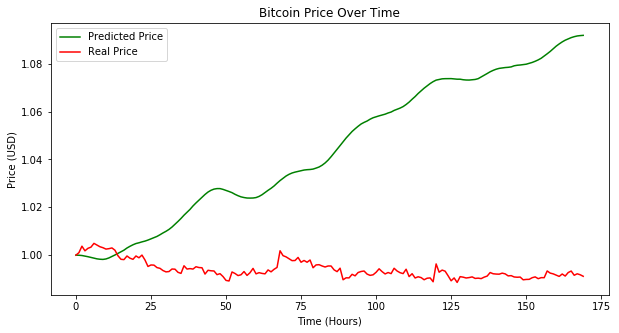

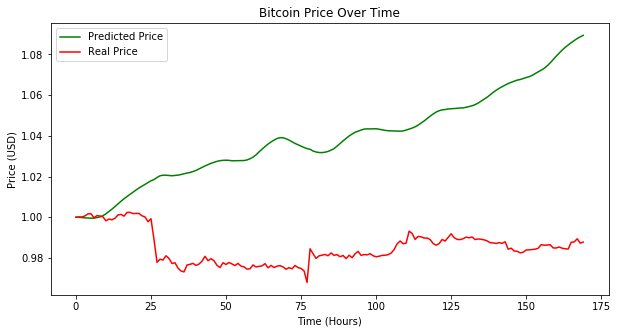

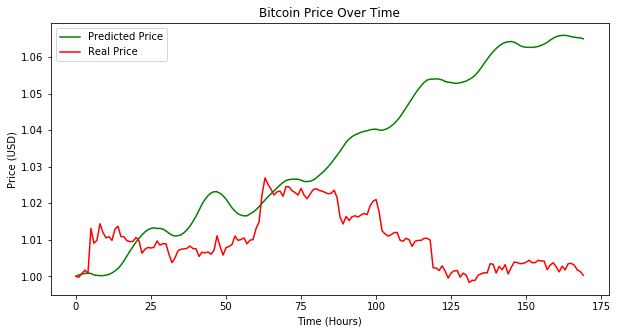

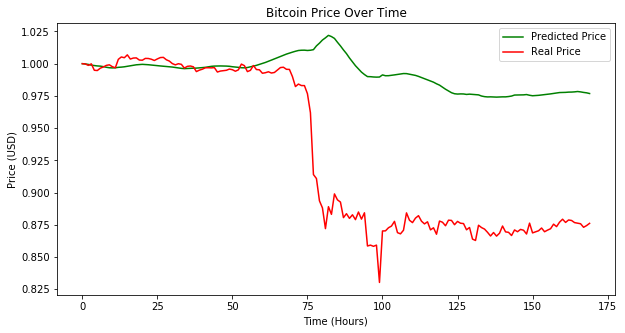

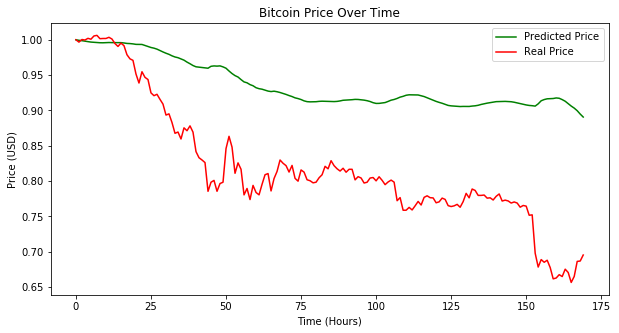

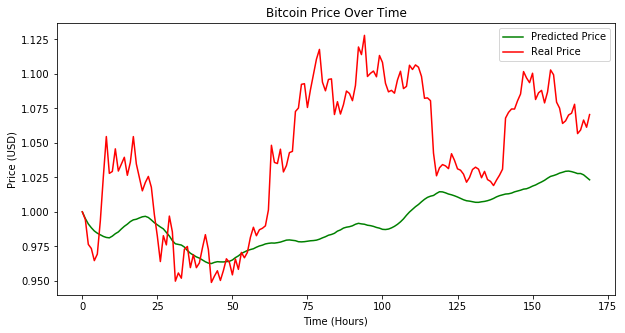

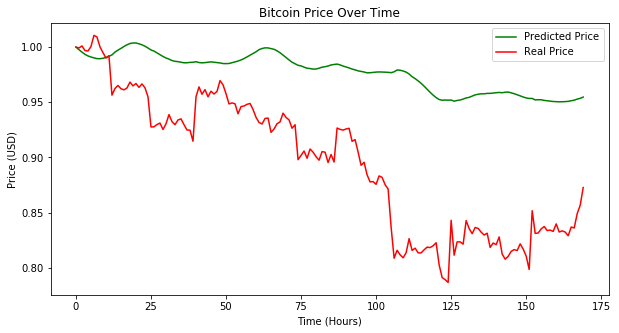

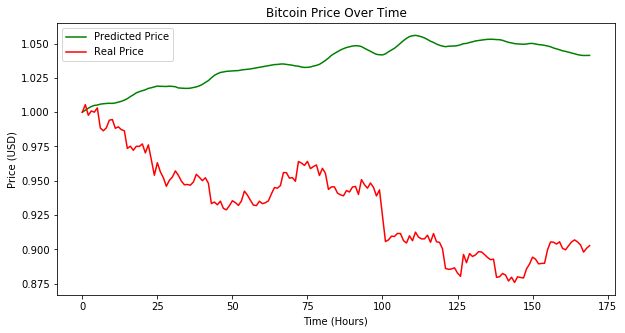

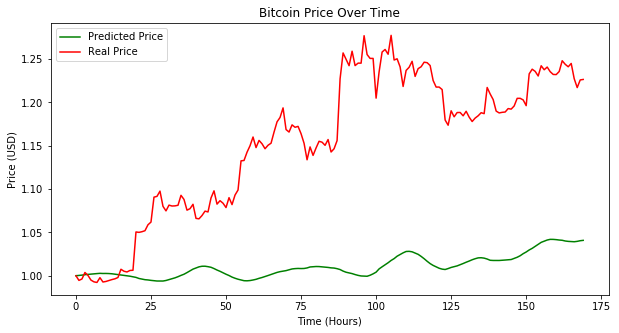

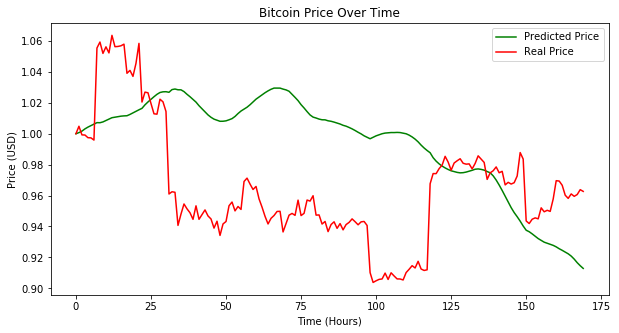

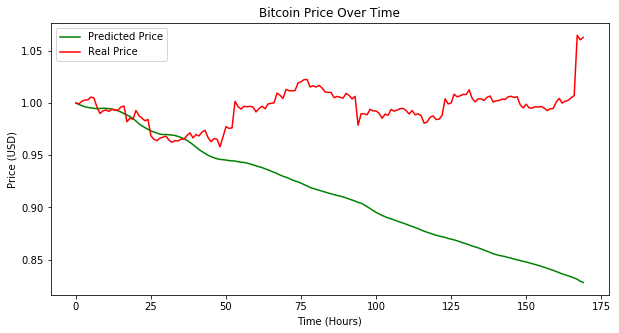

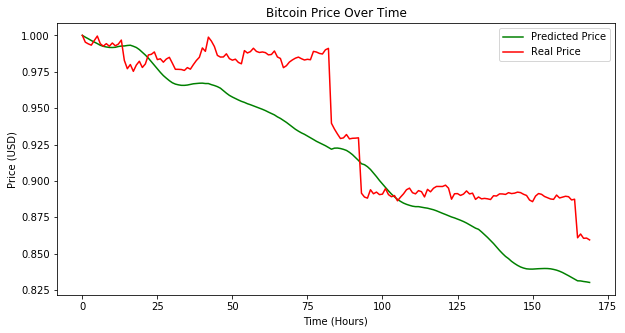

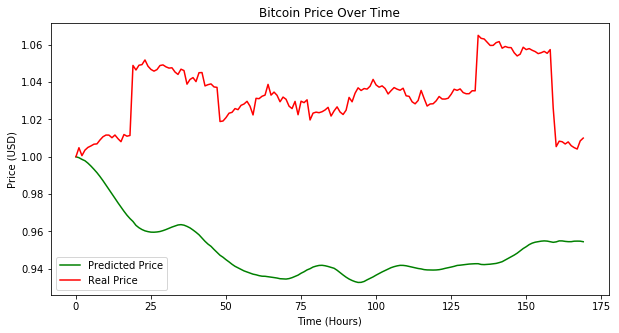

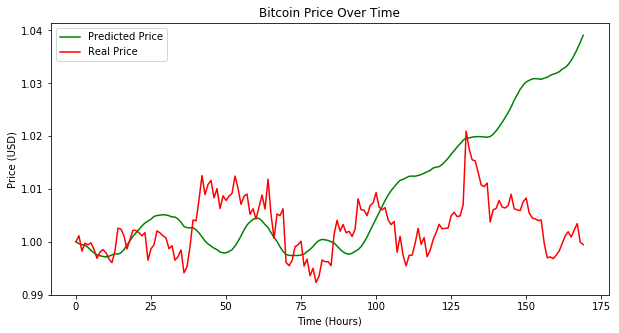

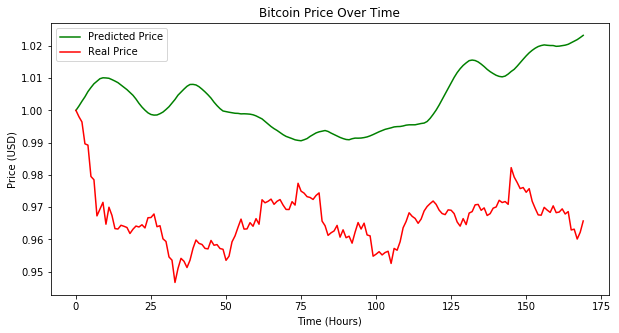

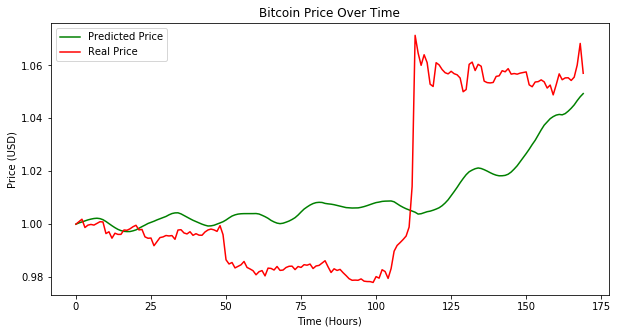

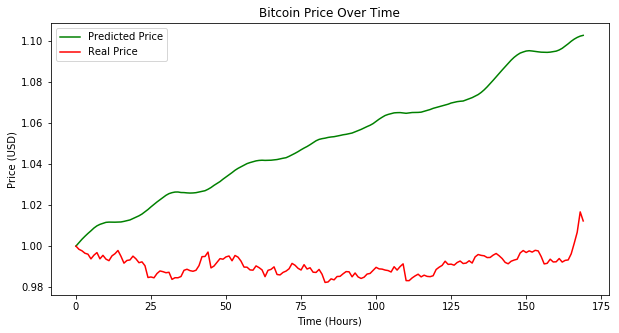

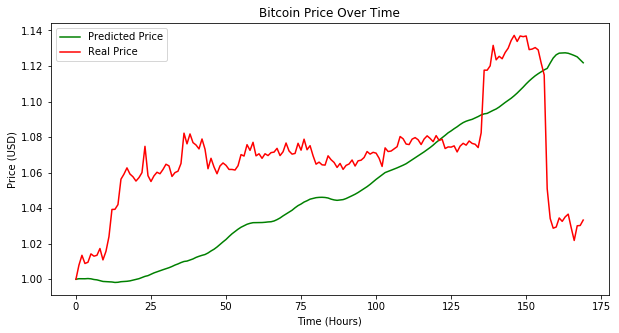

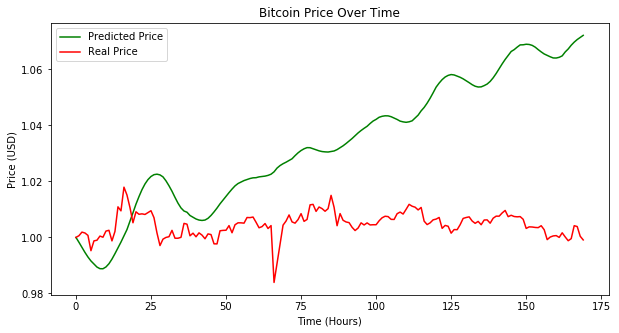

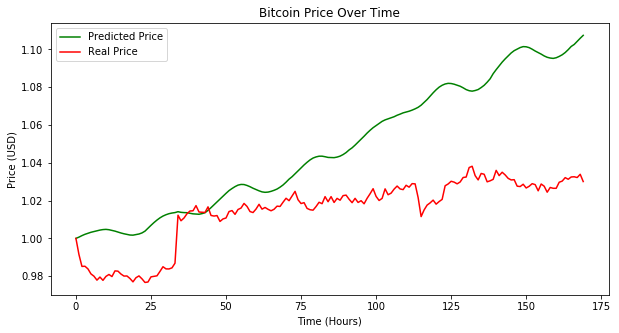

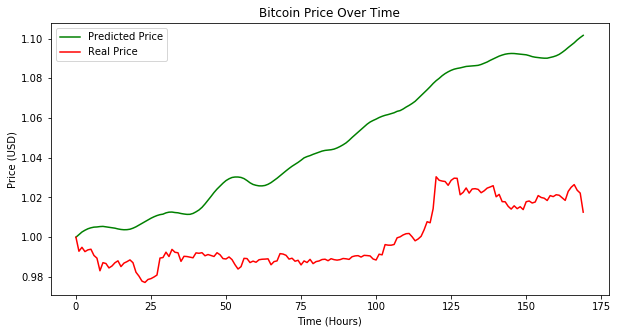

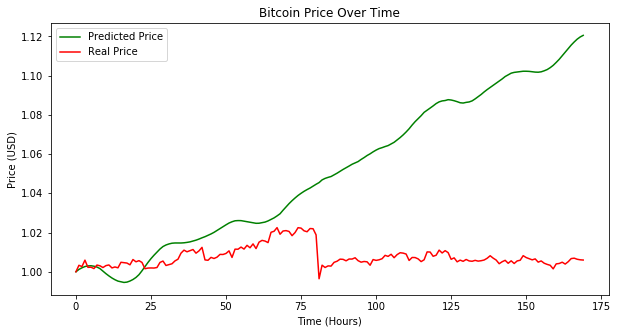

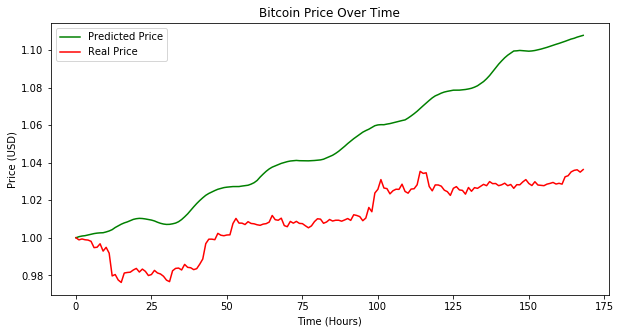

In [46]:
# plot prediction for every 7 days #168hours
n = round(X_test.shape[0]/168)
X_chunk = np.array_split(X_test,n)
Y_chunk = np.array_split(Y_test,n)
for i in range(len(X_chunk)):
    y_predict_slice, fig = test_model(model,X_chunk[i], Y_chunk[i])

In [39]:
y_predict_10, y_actual_10 = binary_price(y_predict,Y_test)
print (y_predict_10.shape)
print (y_actual_10.shape)

(3886, 1)
(3886,)


In [87]:
true_pos, false_pos, true_neg, false_neg = find_positives_negatives(y_predict_10, y_actual_10)
print ("True positives:", true_pos)
print ("False positives:", false_pos)
print ("True negatives:", true_neg)
print ("False negatives:", false_neg)

True positives: 1480
False positives: 1408
True negatives: 514
False negatives: 484


In [40]:
true_pos, false_pos, true_neg, false_neg = find_positives_negatives(y_predict_10, y_actual_10)
print ("True positives:", true_pos)
print ("False positives:", false_pos)
print ("True negatives:", true_neg)
print ("False negatives:", false_neg)

True positives: 1212
False positives: 1138
True negatives: 784
False negatives: 752


In [43]:
calculate_statistics(true_pos, false_pos, true_neg, false_neg, y_predict, Y_test)

(0.5157446808510638,
 0.6171079429735234,
 0.5618915159944367,
 0.5136387030365415,
 0.002380160632255953)